# 03c02 Flow Neighbor MSE

In [ ]:
# default_exp embed
# hide
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import FRED
device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else "cpu")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# export
def flow_neighbor_loss(neighbors, embedded_points, embedded_flows):
    row, col = neighbors
    directions = (embedded_points[col] - embedded_points[row])
    flows = embedded_flows[row]
    loss = torch.norm(directions - flows)**2
    return loss

In [ ]:
# export
def contrastive_flow_loss(not_neighbors, embedded_points, embedded_flows):
    row, col = not_neighbors
    directions = (embedded_points[col] - embedded_points[row])
    flows = embedded_flows[row]
    dist_to_flow = torch.norm(directions - flows)**2
    loss = 1/dist_to_flow
    return loss

In [ ]:
# export
from FRED.data_processing import flashlight_cosine_similarity, affinity_matrix_from_pointset_to_pointset, flashlight_kernel
from torch.nn.functional import cross_entropy
def contrastive_flow_loss_V2(
        embedded_points, # a batch of embedded points
        embedded_flows, # the flows associated to each embedded point
        neighbors, # a list of size batch_size/2, mapping point i in the batch to its neighbor in the batch, neighbor[i]
        use_distance_kernel = False,
        debug = False,
        only_optimize_flow_artist = True,
        ): # Could be a list of positive indices
    # embedded_points = embedded_points.detach()
    if use_distance_kernel:
        A = flashlight_kernel(embedded_points,embedded_flows,kernel_type='fixed',sigma=0.7)
        # A = affinity_matrix_from_pointset_to_pointset(embedded_points, embedded_points, embedded_flows, sigma=0.7, flow_strength=5)
    else:
        A = flashlight_cosine_similarity(embedded_points, embedded_flows) # produces matrix of affinities
    loss = cross_entropy(A,neighbors)
    if not debug:
        return loss
    else: 
        return loss, A

## Experimental validation
Is the flow contrastive loss minimized when each arrow is pointing to its neighbor?

Here's the loss with the arrows pointing to the direct neighbors:

In [ ]:
batch_size = 16

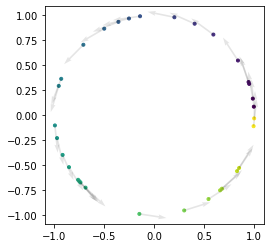

In [ ]:
from FRED.datasets import directed_circle,plot_directed_2d
X, flows, labels = directed_circle(num_nodes=batch_size*2)
X = torch.tensor(X)
flows = torch.tensor(flows)
plot_directed_2d(X,flows,labels,arrow_scale=8,mask_prob=0)

In [ ]:
neighbors = torch.tensor(np.concatenate([np.arange(1,batch_size*2),np.arange(0,1)]))
loss, A = contrastive_flow_loss_V2(X,flows,neighbors,use_distance_kernel=True,debug=True)
print("optimal loss is",loss.item())
neighbors = torch.tensor(np.concatenate([np.arange(1,batch_size*2),np.arange(0,1)]))
loss, A = contrastive_flow_loss_V2(X,-flows,neighbors,use_distance_kernel=True,debug=True)
print("loss with arrows pointing the opposite direction is",loss.item())
neighbors = torch.tensor(np.concatenate([np.arange(1,batch_size*2),np.arange(0,1)]))
flows_t = flows
flow_p = torch.zeros_like(flows_t)
flow_p[:,0] = flows_t[:,1]
flow_p[:,1] = flows_t[:,0]
flow_p = -flow_p
loss, A = contrastive_flow_loss_V2(X,flow_p,neighbors,use_distance_kernel=True,debug=True)
print("loss with arrows perpendicular to points",loss.item())
neighbors = torch.tensor(np.concatenate([np.arange(1,batch_size*2),np.arange(0,1)]))
loss, A = contrastive_flow_loss_V2(torch.tensor(X),flows,neighbors,use_distance_kernel=False,debug=True)
print("optimal loss without distance kernel",loss.item())
neighbors = torch.tensor(np.concatenate([np.arange(1,batch_size*2),np.arange(0,1)]))
loss, A = contrastive_flow_loss_V2(X,-flows,neighbors,use_distance_kernel=False,debug=True)
print("loss with arrows pointing the opposite direction (without distance kernel) is",loss.item())
neighbors = torch.tensor(np.concatenate([np.arange(1,batch_size*2),np.arange(0,1)]))
flows_t = flows
flow_p = torch.zeros_like(flows_t)
flow_p[:,0] = flows_t[:,1]
flow_p[:,1] = flows_t[:,0]
flow_p = -flow_p
loss, A = contrastive_flow_loss_V2(X,flow_p,neighbors,use_distance_kernel=False,debug=True)
print("loss with arrows perpendicular to points (without distance kernel) is ",loss.item())

optimal loss is 2.8608843417185783
loss with arrows pointing the opposite direction is 3.55585578507905
loss with arrows perpendicular to points 3.1845967027004645
optimal loss without distance kernel 2.6943469325594647
loss with arrows pointing the opposite direction (without distance kernel) is 4.679412457652052
loss with arrows perpendicular to points (without distance kernel) is  3.6259214477838198


How does this change with a larger batch size?

In [ ]:
batch_size = 64

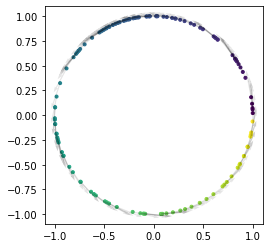

In [ ]:
from FRED.datasets import directed_circle,plot_directed_2d
X, flows, labels = directed_circle(num_nodes=batch_size*2)
X = torch.tensor(X)
flows = torch.tensor(flows)
plot_directed_2d(X,flows,labels,arrow_scale=8,mask_prob=0)

In [ ]:
neighbors = torch.tensor(np.concatenate([np.arange(1,batch_size*2),np.arange(0,1)]))
loss, A = contrastive_flow_loss_V2(X,flows,neighbors,use_distance_kernel=True,debug=True)
print("optimal loss is",loss.item())
neighbors = torch.tensor(np.concatenate([np.arange(1,batch_size*2),np.arange(0,1)]))
loss, A = contrastive_flow_loss_V2(X,-flows,neighbors,use_distance_kernel=True,debug=True)
print("loss with arrows pointing the opposite direction is",loss.item())
neighbors = torch.tensor(np.concatenate([np.arange(1,batch_size*2),np.arange(0,1)]))
flows_t = flows
flow_p = torch.zeros_like(flows_t)
flow_p[:,0] = flows_t[:,1]
flow_p[:,1] = flows_t[:,0]
flow_p = -flow_p
loss, A = contrastive_flow_loss_V2(X,flow_p,neighbors,use_distance_kernel=True,debug=True)
print("loss with arrows perpendicular to points",loss.item())
neighbors = torch.tensor(np.concatenate([np.arange(1,batch_size*2),np.arange(0,1)]))
loss, A = contrastive_flow_loss_V2(torch.tensor(X),flows,neighbors,use_distance_kernel=False,debug=True)
print("optimal loss without distance kernel",loss.item())
neighbors = torch.tensor(np.concatenate([np.arange(1,batch_size*2),np.arange(0,1)]))
loss, A = contrastive_flow_loss_V2(X,-flows,neighbors,use_distance_kernel=False,debug=True)
print("loss with arrows pointing the opposite direction (without distance kernel) is",loss.item())
neighbors = torch.tensor(np.concatenate([np.arange(1,batch_size*2),np.arange(0,1)]))
flows_t = flows
flow_p = torch.zeros_like(flows_t)
flow_p[:,0] = flows_t[:,1]
flow_p[:,1] = flows_t[:,0]
flow_p = -flow_p
loss, A = contrastive_flow_loss_V2(X,flow_p,neighbors,use_distance_kernel=False,debug=True)
print("loss with arrows perpendicular to points (without distance kernel) is ",loss.item())

optimal loss is 4.100853289227099
loss with arrows pointing the opposite direction is 4.9050499763904085
loss with arrows perpendicular to points 4.5102533231052435
optimal loss without distance kernel 4.189987862931081
loss with arrows pointing the opposite direction (without distance kernel) is 5.979923745412609
loss with arrows perpendicular to points (without distance kernel) is  4.981742533044305


Even with very large batch sizes, the optimal loss is the lowest. The problem then seems to be that gradient information is not flowing through the loss function to the flow artist.